# Chi-Squared Independence Test


> Use Case
- Used to compare observed and expected frequencies of categorical data, particularly when comparing proportions across different categorical groups.
- Used for feature selection, to determine is a feature is a good predictor.
> Assumptions
- The data must be categorical and fit into a contingency table.
- The expected frequency in each cell of the contingency table should be at least 5 (to ensure the validity of the test).
> Example Scenario
- Comparing the satisfaction levels of customers (Satisfied/Not Satisfied) between two different versions of a website.
> Null Hypothesis (H0):
- Feature Selection: The categories are independent
- Proportions: The proportion of successes is the same for both groups.
> Alternative Hypothesis (H1):
- Feature Selection: The categories are dependent
- Proportions: The proportion of successes is different for both groups.

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statsmodels==0.12.2
from statsmodels.stats.power import GofChisquarePower
from statsmodels.stats.proportion import proportions_chisquare

# scipy==1.12.0
from scipy.stats import chi2_contingency

# pingouin==0.5.4
from pingouin import chi2_independence, power_chi2 


In [102]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [103]:
import scipy
scipy.__version__

'1.12.0'

In [104]:
import pingouin
pingouin.__version__

'0.5.4'

In [105]:
# Set random seed for reproducibility
np.random.seed(42)

In [106]:
# set seaborn style
sns.set(style="white", palette="mako")

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

### Power Analysis

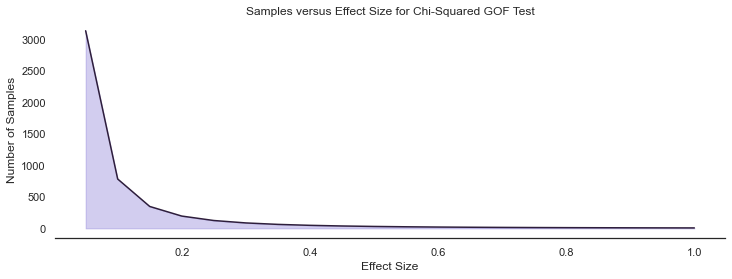

In [107]:
# Initialize GofChisquarePower
gof_power = GofChisquarePower()

# Given power and alpha
alpha=0.05
power=0.8

# Define effect sizes
effect_sizes = np.linspace(0.05, 1, 20) 
# Calculate number of samples for each effect size
samples = [gof_power.solve_power(effect_size=effect_size, nobs=None, alpha=alpha, power=power) for effect_size in effect_sizes]

# Figure size
plt.figure(figsize=(12, 4))

# Plot samples versus effect sizes
plt.plot(effect_sizes, samples)

# Shade area below the line with lower opacity
plt.fill_between(effect_sizes, samples, color='slateblue', alpha=0.3)

# Add plot labels and title
plt.xlabel('Effect Size')
plt.ylabel('Number of Samples')
plt.title('Samples versus Effect Size for Chi-Squared GOF Test')
plt.show()


In [108]:
# Chi-Squared Power Analysis (scipy)

# Degree of freedom (depends on the chosen test).
dof=3
# Cohen’s w effect size
w=0.3
# Test power (= 1 - type II error).
power=0.8
# Significance level (type I error probability).
alpha=0.05
# Exactly ONE of the parameters w, n, power and alpha must be passed as None, and that parameter is determined from the others. 
n=None

# The degrees of freedom dof must always be specified
sample_size = power_chi2(dof=dof, w=w, n=n, power=power, alpha=alpha)

print(f"There are {int(np.ceil(sample_size))} samples required per group")

There are 122 samples required per group


In [109]:
# Chi-Squared Power Analysis (statsmodels)

# Effect size
effect_size = 0.3
# Significance level (type I error probability).
alpha = 0.05
# Test power (= 1 - type II error).
power = 0.8
# Degree of freedom + 1 (depends on the chosen test).
n_bins=4
# Exactly ONE of the parameters must be passed as None, and that parameter is determined from the others. 
nobs = None

# The degrees of freedom dof must always be specified
sample_size = GofChisquarePower().solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha, power=power, n_bins=n_bins)

print(f"There are {int(np.ceil(sample_size))} samples required per group")

There are 122 samples required per group


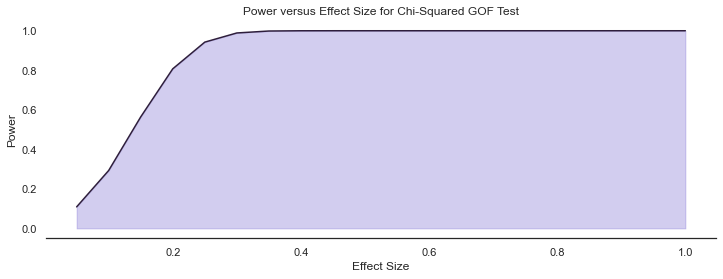

In [110]:
# Initialize GofChisquarePower
gof_power = GofChisquarePower()

# Given alpha 
alpha=0.05
# Given prior determined sample size
nobs = 200


# Define effect sizes
effect_sizes = np.linspace(0.05, 1, 20)  
# Calculate power for each effect size
powers = [gof_power.solve_power(effect_size=effect_size, nobs=nobs, alpha=alpha) for effect_size in effect_sizes]

# Figure size
plt.figure(figsize=(12, 4))

# Plot power versus effect sizes
plt.plot(effect_sizes, powers)

# Shade area below the line with lower opacity
plt.fill_between(effect_sizes, powers, color='slateblue', alpha=0.3)

# Add plot labels and title
plt.xlabel('Effect Size')
plt.ylabel('Power')
plt.title('Power versus Effect Size for Chi-Squared GOF Test')
plt.show()


### Synthetic Data

In [111]:
# Number of samples for each version
n_samples = 500

# Generate synthetic data for two website versions
version_A = np.random.choice(['Satisfied', 'Not Satisfied'], size=n_samples, p=[0.8, 0.2])
version_B = np.random.choice(['Satisfied', 'Not Satisfied'], size=n_samples, p=[0.1, 0.9])


# Create pandas dataframe
chi_squared_data = pd.DataFrame({'Version_A': version_A, 'Version_B': version_B})
chi_squared_data

,Version_A,Version_B
0,Satisfied,Not Satisfied
1,Not Satisfied,Not Satisfied
2,Satisfied,Not Satisfied
3,Satisfied,Not Satisfied
4,Satisfied,Not Satisfied
...,...,...
495,Satisfied,Satisfied
496,Satisfied,Not Satisfied
497,Satisfied,Not Satisfied
498,Not Satisfied,Not Satisfied


In [112]:
# We'll use these later to build arrays to plug into the statistical functions

a_positive = chi_squared_data['Version_A'].value_counts()['Satisfied']
a_negative = chi_squared_data['Version_A'].value_counts()['Not Satisfied']

b_positive = chi_squared_data['Version_B'].value_counts()['Satisfied']
b_negative = chi_squared_data['Version_B'].value_counts()['Not Satisfied']

### Check Assumptions

In [113]:
# Assumption check for chi-squared test
observed_counts = pd.crosstab(chi_squared_data['Version_A'], chi_squared_data['Version_B'])
min_expected_count = 5

# Check if expected counts in each cell are at least > min_expected_count
expected_counts = np.outer(observed_counts.sum(axis=1), observed_counts.sum(axis=0)) / chi_squared_data.shape[0]
assumption_met = np.all(expected_counts >= min_expected_count)

print(f"Chi-Squared Test Assumption: Expected counts in each cell are at least {min_expected_count} - {'Met' if assumption_met else 'Not Met'}")


Chi-Squared Test Assumption: Expected counts in each cell are at least 5 - Met


### Chi-Squared Test (scipy)

In [114]:
# Pre-determined alpha value
alpha = 0.1

In [115]:
# Assuming chi-squared assumptions are met

# Contingency table
# observed_counts = np.array([[a_positive, a_negative], [a_positive, a_negative]])
observed_counts = np.array([[a_positive, a_negative], [b_positive, b_negative]])

# Chi-squared test
res = chi2_contingency(observed_counts, correction=True)

chi2_stat = res.statistic
p_value = res.pvalue
dof = res.dof
expected_freq = res.expected_freq

# Similar categorical variables should present low chi-squared statistic and high p-value.
print(f"Chi-Squared Test Statistic: {chi2_stat}")
print(f"p-value: {p_value}")
print(f"dof: {dof}")
print(f"expected_freq: {expected_freq}")
print("\n")


# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis. The categories are likely dependent"
    interpretation = "There is a significant difference in satisfaction levels between the two website versions."

else:
    conclusion = "Fail to reject the null hypothesis. The categories are likely independent"
    interpretation = "There is no significant difference in satisfaction levels between the two website versions."


print(conclusion)
print(interpretation)


Chi-Squared Test Statistic: 497.90473558210147
p-value: 2.7155602149956693e-110
dof: 1
expected_freq: [[218.5 281.5]
 [218.5 281.5]]


Reject the null hypothesis. The categories are likely dependent
There is a significant difference in satisfaction levels between the two website versions.


### Chi-Squared Test (pingouin)

In [116]:
# Pre-determined alpha value
alpha = 0.1

In [117]:

# # Perform chi-squared test for proportions using pingouin (bootstrap)
# expected, observed, stats = chi2_independence(chi_squared_data, x='Version_A', y='Version_B', correction=True)

# print(f'Expected Counts:')
# display(expected)

# print(f'\nObserved Counts:')
# display(observed)

# # Similar categorical variables should present low chi-squared statistics and high p-values.
# print("Summary Stats:")
# display(stats.round(3))

# avg_p = stats['pval'].mean()

# # Check for statistical significance
# if avg_p < alpha:
#     conclusion = "Reject the null hypothesis. The categories are likely dependent"
#     interpretation = "There is a significant difference in satisfaction levels between the two website versions."
# else:
#     conclusion = "Fail to reject the null hypothesis. The categories are likely independent"
#     interpretation = "There is no significant difference in satisfaction levels between the two website versions."

# print(conclusion)
# print(interpretation)

### Chi-Squared Test (statsmodels)

In [118]:
# Pre-determined alpha value
alpha = 0.1

In [119]:
# Contingency table
# observed_counts = [a_positive, a_positive]
observed_counts = [a_positive, b_positive]

# Get the total number of observations for all categories
nobs = np.array((chi_squared_data.shape[0], chi_squared_data.shape[0]))



# Perform chi-squared test for proportions
chi2_stat, p_value, (table, expected)  = proportions_chisquare(observed_counts, nobs=nobs, value=None)

# Similar categorical variables should present low chi-squared statistics and high p-values.
print(f"Chi-Squared Test Statistic: {chi2_stat}")
print(f"p-value: {p_value}")
print(f"table: {table}")
print(f"expected_freq: {expected}")
print("\n")

# Check for statistical significance
if p_value < alpha:
    conclusion = "Reject the null hypothesis. The categories are likely dependent"
    interpretation = "There is a significant difference in satisfaction levels between the two website versions."
else:
    conclusion = "Fail to reject the null hypothesis. The categories are likely independent"
    interpretation = "There is no significant difference in satisfaction levels between the two website versions."

print(conclusion)
print(interpretation)


Chi-Squared Test Statistic: 500.75397002816715
p-value: 6.515111916280444e-111
table: [[394 106]
 [ 43 457]]
expected_freq: [[218.5 281.5]
 [218.5 281.5]]


Reject the null hypothesis. The categories are likely dependent
There is a significant difference in satisfaction levels between the two website versions.


### Summary Table

In [120]:
# Count everything up
total_count = chi_squared_data.size
group_a_count = chi_squared_data['Version_A'].count()
group_b_count = chi_squared_data['Version_B'].count()

group_a_positive_count = chi_squared_data['Version_A'].value_counts()['Satisfied']
group_a_negative_count = chi_squared_data['Version_A'].value_counts()['Not Satisfied']

group_b_positive_count = chi_squared_data['Version_B'].value_counts()['Satisfied']
group_b_negative_count = chi_squared_data['Version_B'].value_counts()['Not Satisfied']

In [121]:
# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'Test Group': ["Group A", "Group B"],
    'Total': [group_a_count, group_b_count],
    'Satisfied': [group_a_positive_count, group_b_positive_count],
    'Not Satisfied': [group_a_negative_count, group_b_negative_count],
    'Satisfied Rate': [group_a_positive_count/group_a_count, group_b_positive_count/group_b_count],
}, index=[0, 1])
plot_data

,Test Group,Total,Satisfied,Not Satisfied,Satisfied Rate
0,Group A,500,394,106,0.788
1,Group B,500,43,457,0.086


### Visualization

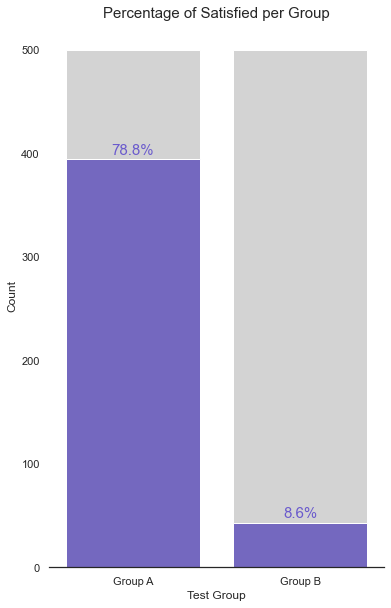

In [122]:
# Plot stacked bars
plt.figure(figsize=(6, 10))

plot_total = sns.barplot(x=plot_data['Test Group'], 
                        y=plot_data['Total'], color='lightgrey')

plot_satisfied = sns.barplot(x=plot_data['Test Group'], 
                            y=plot_data['Satisfied'], color='slateblue')

# Set labels and title
plt.title('Percentage of Satisfied per Group', fontsize=15)
plt.ylabel('Count')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

# Put values on top of bars
row_list = []
for index, row in plot_data[plot_data['Test Group'] == 'Group A'][['Satisfied', 'Satisfied Rate']].iterrows():
    plot_total.text(row.name, row['Satisfied']+5, str(round(100 * row['Satisfied Rate'], 2)) + '%', color='slateblue', ha="center", fontsize=15)
for index, row in plot_data[plot_data['Test Group'] == 'Group B'][['Satisfied', 'Satisfied Rate']].iterrows():
    plot_satisfied.text(row.name, row['Satisfied']+5, str(round(100 * row['Satisfied Rate'], 2)) + '%', color='slateblue', ha="center", fontsize=15)
# Show the plot
plt.show()

# Fisher's Exact Test

> Fisher's Exact Test:
Purpose: Fisher's Exact Test is used to determine whether there are nonrandom associations between two categorical variables in a contingency table, especially when sample sizes are small.
Application: It is commonly used when the sample sizes are small or when the Chi-Squared Test assumptions are violated (e.g., expected cell frequencies are less than 5).
Calculation: Fisher's Exact Test calculates the probability of observing a particular arrangement of data, given the marginal totals, under the null hypothesis of independence.
Advantage: It provides an exact p-value for the test, making it useful when sample sizes are small.
Limitation: Computationally intensive for large contingency tables.

> Chi-Squared Test:
Purpose: The Chi-Squared Test assesses whether there is a significant association between two categorical variables in a contingency table.
Application: It is widely used when analyzing categorical data, especially in larger sample sizes.
Calculation: The Chi-Squared Test calculates the discrepancy between the observed and expected frequencies in each cell of the contingency table, and then sums these discrepancies to obtain the Chi-Squared statistic.
Advantage: It is relatively straightforward to compute and interpret, making it a popular choice for analyzing categorical data.
Limitation: Less accurate for small sample sizes or when expected cell frequencies are low.

# Chi Sqiared Goodness of Fit

In [123]:
# from scipy.stats import chisquare

# # Function to run Goodness of Fit test
# def run_goodness_of_fit_test(data, expected_distribution):
#     # Calculate observed frequencies
#     observed_counts = data.sum()

#     # Calculate expected counts based on the provided distribution
#     total_samples = len(data)
#     expected_counts = total_samples * np.array(expected_distribution)

#     # Run the Goodness of Fit test
#     chi2_stat, p_value = chisquare(observed_counts, f_exp=expected_counts)

#     print(f'Goodness of Fit Test: Chi-squared Statistic={chi2_stat}, p-value={p_value}')

#     # Interpret the results
#     alpha = 0.05
#     if p_value < alpha:
#         print('Reject the null hypothesis: There is a significant difference between observed and expected distributions.')
#     else:
#         print('Fail to reject the null hypothesis: There is no significant difference between observed and expected distributions.')

# # Example usage for A/B test data and expected distribution
# run_goodness_of_fit_test(ab_test_data, expected_distribution)